# Using composition-based features to train the Neural Network model for e_electronic prediction

- Get data from file

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression

In [2]:
# some constants
TEST_SIZE = 0.30
RANDOM_STATE = 42

FIG_PATH = '../figures/composition_based/unClustered/e_electronic/'

In [3]:
data = pd.read_csv('../data/composition_based_data.csv')

In [4]:
data.head()

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,e_electronic,e_ionic,e_total
0,16.0,56.0,40.0,30.285714,16.326531,16.0,9.0,88.0,79.0,69.285714,...,0.0,70.0,229.0,159.0,137.000000,76.571429,70.0,9.929365,7.118969,17.048334
1,8.0,41.0,33.0,16.500000,12.250000,8.0,47.0,93.0,46.0,78.500000,...,0.0,12.0,229.0,217.0,67.000000,81.000000,12.0,4.102533,13.469477,17.572010
2,16.0,38.0,22.0,24.000000,9.142857,16.0,8.0,88.0,80.0,75.428571,...,0.0,70.0,225.0,155.0,119.571429,56.653061,70.0,6.045051,12.443616,18.488667
3,8.0,26.0,18.0,11.083333,4.125000,8.0,2.0,88.0,86.0,77.416667,...,0.0,12.0,229.0,217.0,57.833333,61.111111,12.0,3.096120,6.499905,9.596025
4,1.0,9.0,8.0,5.200000,3.400000,1.0,72.0,93.0,21.0,89.400000,...,0.0,15.0,194.0,179.0,119.600000,83.680000,15.0,1.866232,4.350314,6.216546


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7262 entries, 0 to 7261
Columns: 135 entries, MagpieData minimum Number to e_total
dtypes: float64(135)
memory usage: 7.5 MB


- Create X and y

In [6]:
X = data.drop(columns=['e_total', 'e_ionic', 'e_electronic'])
y = data['e_electronic']

In [7]:
X.shape

(7262, 132)

- Train and Test set split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

- 搭建模型

In [9]:
# for load data
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data.to_numpy()
        self.targets = targets.to_numpy().reshape(-1, 1)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # get data and target according to index, and convert them to tensor
        x = torch.tensor(self.data[index], dtype=torch.float32)
        y = torch.tensor(self.targets[index], dtype=torch.float32)
        return x, y
    
# Create dataset
dataset = CustomDataset(X_train, y_train) 
# Create data loader
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
X_train.shape

(5083, 132)

In [11]:
# Create a neural network model
import torch.nn as nn
import torch.optim as optim

class NN_model(nn.Module):
    def __init__(self):
        super(NN_model, self).__init__()
        # Define the neural network layers
        self.layers = nn.Sequential(
            nn.BatchNorm1d(132),
            nn.Linear(132, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

## Model Train

In [12]:
device = torch.device('cpu')

print(device)
# define hyperparameters
input_size = X_train.shape[1]
output_size = 1
learning_rate = 0.0007
num_epochs = 1200

model = NN_model()
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)
criterion.to(device)
# train
model.train()
for epoch in range(num_epochs):
    # Forward pass
    epoch_loss = 0
    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)
        outputs = model(features)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        # Backward and optimize
        optimizer.zero_grad()    
        loss.backward()
        optimizer.step() 

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, MSE: {epoch_loss/len(dataset):.4f}')

cpu
Epoch [50/1200], Loss: 6813.7212, MSE: 1.3405
Epoch [100/1200], Loss: 3728.2985, MSE: 0.7335
Epoch [150/1200], Loss: 3868.7859, MSE: 0.7611
Epoch [200/1200], Loss: 3192.1329, MSE: 0.6280
Epoch [250/1200], Loss: 1967.7040, MSE: 0.3871
Epoch [300/1200], Loss: 1825.3376, MSE: 0.3591
Epoch [350/1200], Loss: 1557.2901, MSE: 0.3064
Epoch [400/1200], Loss: 1484.0978, MSE: 0.2920
Epoch [450/1200], Loss: 1566.1101, MSE: 0.3081
Epoch [500/1200], Loss: 1388.3225, MSE: 0.2731
Epoch [550/1200], Loss: 1316.4935, MSE: 0.2590
Epoch [600/1200], Loss: 1124.9150, MSE: 0.2213
Epoch [650/1200], Loss: 2171.3968, MSE: 0.4272
Epoch [700/1200], Loss: 1136.9910, MSE: 0.2237
Epoch [750/1200], Loss: 982.9656, MSE: 0.1934
Epoch [800/1200], Loss: 973.0245, MSE: 0.1914
Epoch [850/1200], Loss: 595.4183, MSE: 0.1171
Epoch [900/1200], Loss: 898.8659, MSE: 0.1768
Epoch [950/1200], Loss: 652.7658, MSE: 0.1284
Epoch [1000/1200], Loss: 893.6721, MSE: 0.1758
Epoch [1050/1200], Loss: 704.1706, MSE: 0.1385
Epoch [1100/120

In [13]:
# draw parity plot
def parity_plot(mse, mae, y_test, y_pred, y_name="e_electronic", title='Parity Plot', fig_path=None, dpi=300):
    # draw parity plot
    fig, ax = plt.subplots(figsize=(8, 8), dpi=dpi)
    ax.scatter(y_test, y_pred, s=2, c="#9cc3e5", marker="^")
    ax.plot(y_test, y_test, c="#aad390", zorder=-5)
    ax.set_title(title)
    # relative dielectric constant, no unit
    ax.set_xlabel("Actual " + y_name)
    ax.set_ylabel("Predicted " + y_name)
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    # make it diagonal distribution
    ax.set_aspect("equal", adjustable="box")
    # set the range of x and y to be the same
    ax.set_xlim([0, 50])
    ax.set_ylim([0, 50])
    # inward ticks
    ax.tick_params(axis='both', direction='in', length=4) 

    ax.grid(True, linestyle="--", alpha=0.4)
    
    # draw mse and mae on the plot of top_left
    # Add bbox to the plot
    bbox_props = dict(boxstyle="round,pad=0.8", ec="#aad390", lw=0.6, facecolor="white", alpha=0.6)
    ax.text(0.05, 0.95, "MSE: {:.2f}\n\nMAE: {:.2f}".format(mse, mae), transform=ax.transAxes, 
            fontsize=6, c='#9cc3e5', verticalalignment='top', bbox=bbox_props)

    plt.show()
    if fig_path:
        # Is there the directory of the fig_path
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig.savefig(fig_path+title+".png", dpi=dpi, bbox_inches='tight')


def plot_scores(y_train, y_hat, title='Parity Plot', fig_path=None, dpi=300):
    '''...'''
    # calculate mse and mae
    mse = mean_squared_error(y_train, y_hat)
    mae = mean_absolute_error(y_train, y_hat)
    print(f'MSE: {mse}, MAE: {mae}')

    # parity plot
    parity_plot(mse, mae, y_train, y_hat, y_name='e_electronic', title=title, fig_path=fig_path, dpi=dpi)


- Compare the predicted values of the training set with the predicted values of the test set 
to see if the model is overfitting

In [14]:
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_train_tensor = X_train_tensor.to(device)

MSE: 22.601319878854383, MAE: 1.0777160981222436


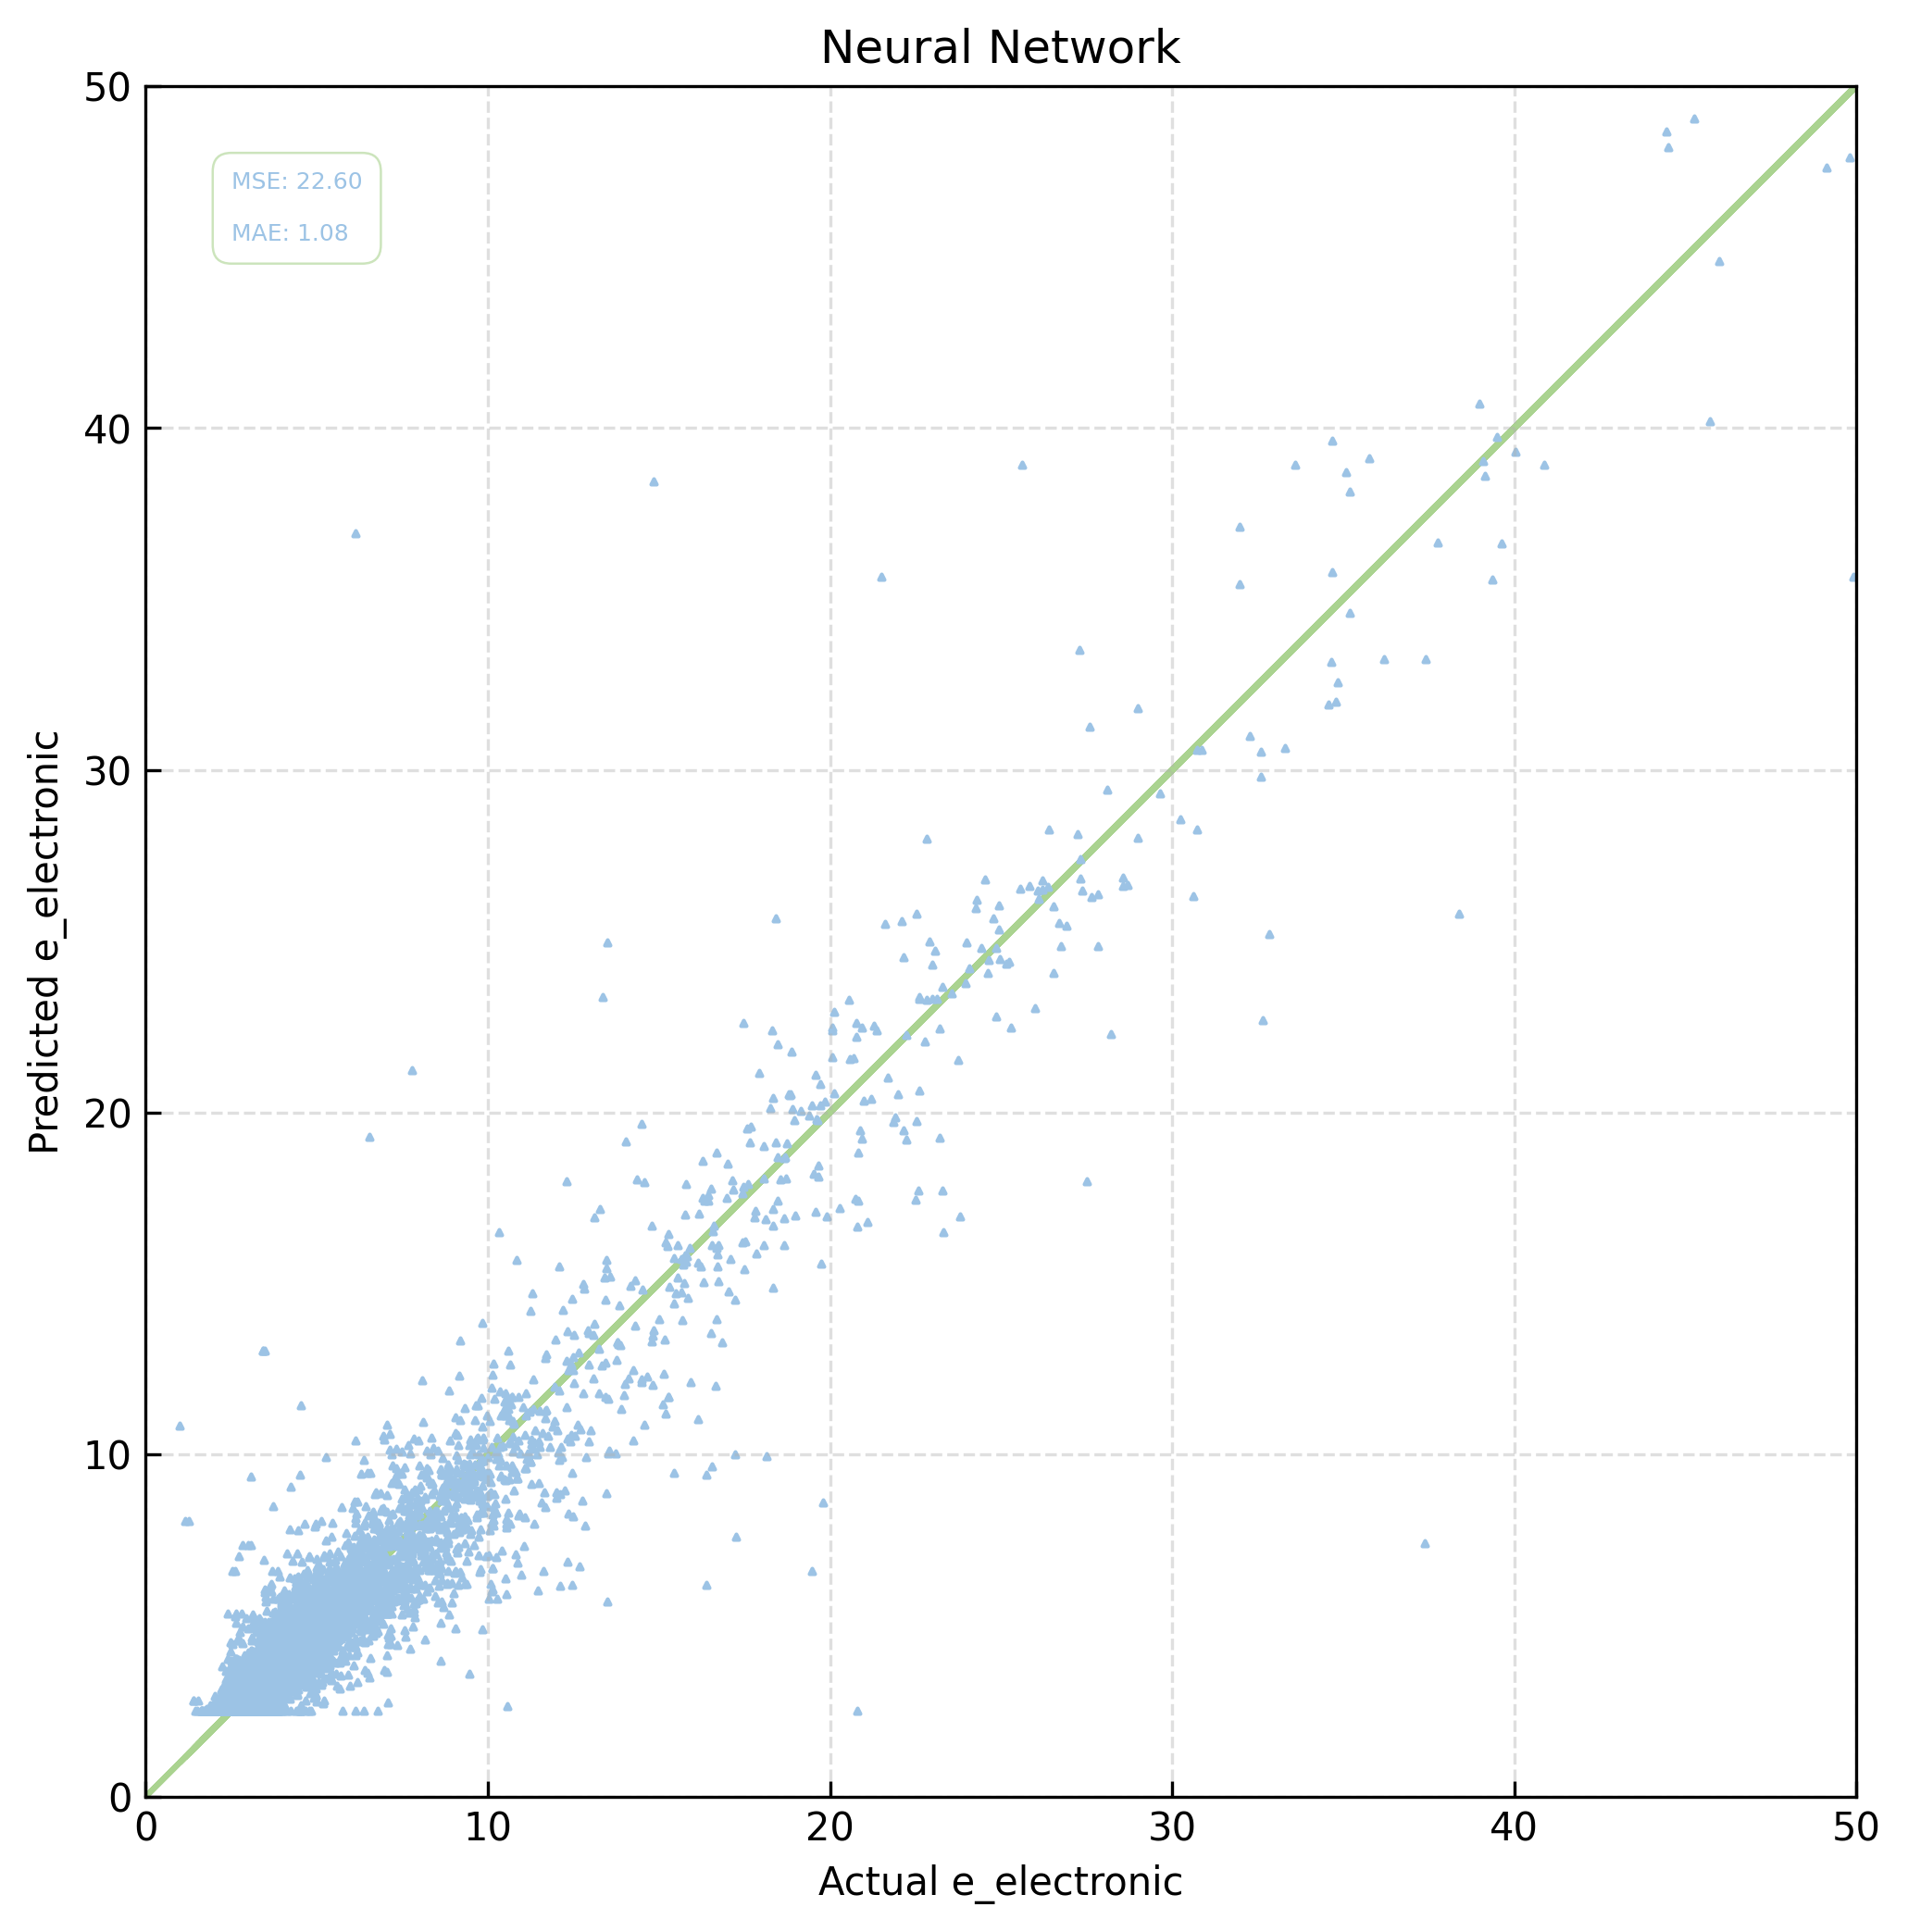

In [15]:
y_hat = model(X_train_tensor)

    
plot_scores(y_train, y_hat.detach().cpu().numpy(), title='Neural Network', fig_path=None)

## Model Test

In [16]:
y_pred = model(torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device))

MSE: 111.36201743903277, MAE: 2.0836748081803997


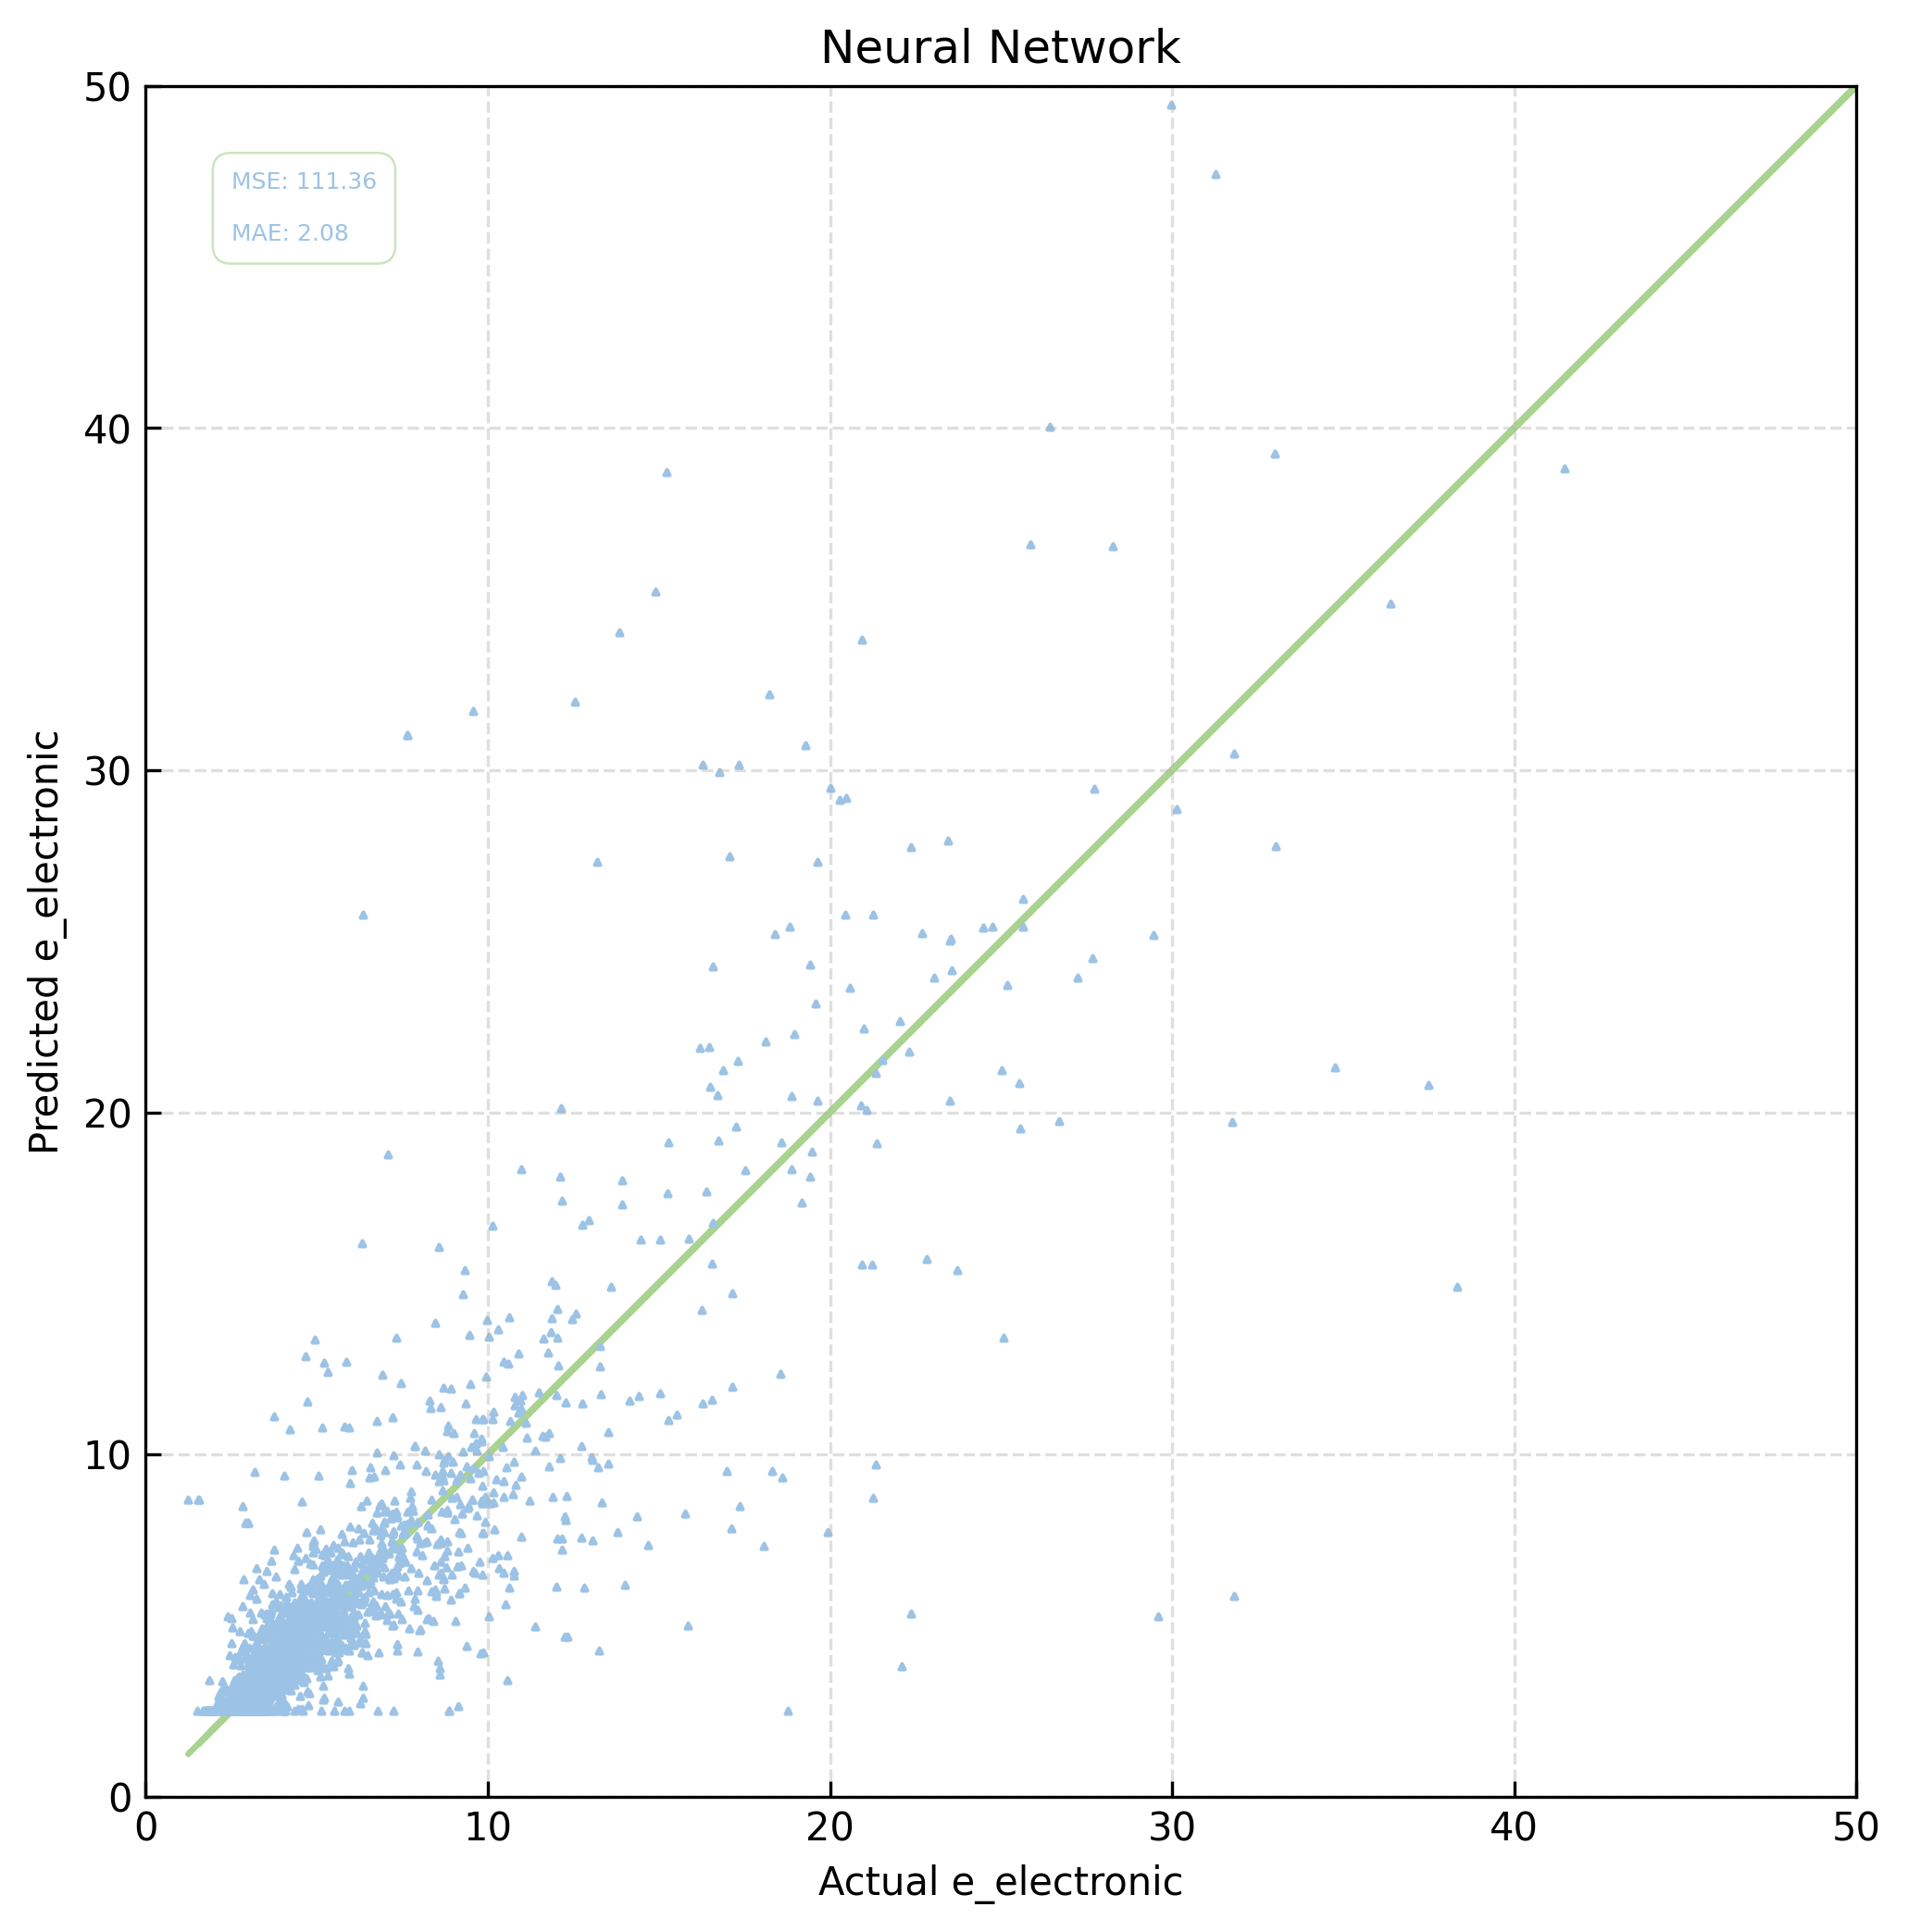

In [17]:
plot_scores(y_test, y_pred.detach().cpu().numpy(), title='Neural Network', fig_path=FIG_PATH)

- No overfitting